In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import cupy as cp
from astropy import units as u
import blimpy as bl
import scipy.integrate

import setigen as stg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

In [6]:
fr = stg.Frame.from_backend_params(430)
fr.get_params()

{'fchans': 430,
 'tchans': 16,
 'df': 2.7939677238464355,
 'dt': 18.253611008,
 'fch1': 8000000000.0,
 'ascending': False}

In [25]:
T*dF

520.0

In [32]:
scipy.special.fresnel([[1,2,3]])

(array([[0.43825915, 0.34341568, 0.496313  ]]),
 array([[0.7798934 , 0.48825341, 0.60572079]]))

In [58]:
A = np.random.normal(size=5)
np.where(A>0, A, -10)

array([-10.        ,   0.62839447,   1.67766915,   0.56894113,
       -10.        ])

In [49]:
dF

27.939677238464355

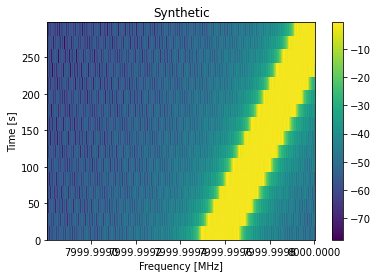

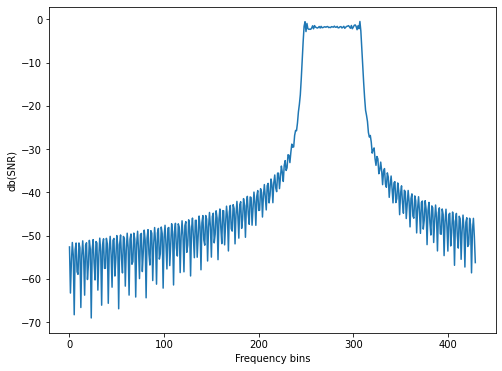

In [65]:
# RESET THE FRAME EVERY TIME 
fr = stg.Frame.from_backend_params(430, 16)

drift_factor = 10
drift_rate = fr.df/fr.dt * drift_factor

T = fr.dt
dF = drift_rate * T
dO = 2 * np.pi * dF

def get_Xs(f):
    num1 = dO / 2 + (dO - f)
    num2 = dO / 2 - (dO - f)
    den = np.sqrt(np.pi * dO / T)
    return num1 / den, num2 / den

def A(f, f_center):
    const = np.pi * T / dO
    df = f - f_center
    
    X1, X2 = get_Xs(df)
    C1, S1 = scipy.special.fresnel(X1)
    C2, S2 = scipy.special.fresnel(X2)
    Spec = const * ((C1 + C2)**2 + (S1 + S2)**2)
    return Spec
#     return np.where(np.abs(f - f_center) > dF / 2, Spec, 0)
#     print(np.where(np.abs(f - f_center) > dF / 2))
#     Spec[np.where(np.abs(f - f_center) > dF / 2)] = 0
#     return Spec
    

fr.add_signal(stg.constant_path(f_start=fr.get_frequency(index=fr.fchans//2),
                                  drift_rate=drift_rate),
                          stg.constant_t_profile(level=1),
                          A,
                          stg.constant_bp_profile(level=1))
fr.bl_plot()
plt.show()

# s_fr.data += 1e-12
plt.figure(figsize=(8, 6))
spectrum = fr.data[i]
plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

In [49]:
sample_rate = 3e9 // 1
num_taps = 8
num_branches = 1024 // 1

fftlength = 1048576
int_factor = 51
obs_length = 300

chan_bw = sample_rate / num_branches
fine_chan_bw = chan_bw / fftlength
f_start = fine_chan_bw * int(fftlength*(2+0.6-0.5))
wf = bl.Waterfall('drifting.rawspec.0000.fil',
                  f_start=f_start/1e6 - 3*200/1e6,
                  f_stop=f_start/1e6 + 3*200/1e6)

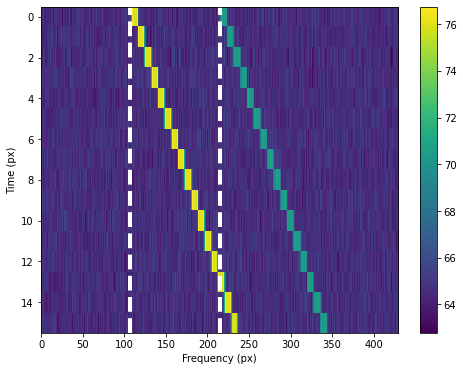

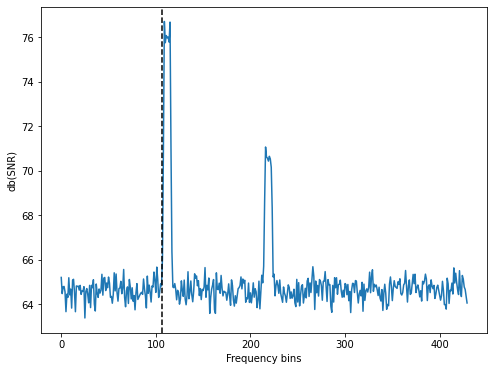

In [154]:
# RESET THE FRAME EVERY TIME 
# fr = stg.Frame.from_backend_params(430, 16)

wf = bl.Waterfall('drifting.rawspec.0000.fil',
                  f_start=f_start/1e6 - 3*200/1e6,
                  f_stop=f_start/1e6 + 3*200/1e6)
fr = stg.Frame.from_waterfall(wf)

drift_factor = 8
drift_rate = fr.df/fr.dt * drift_factor

def analytic_chirp(drift_rate, dt):
    """
    Chirp spectrum, from https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dO = drift_rate * T 
    const = np.pi * T / dO

    def f_profile(f, f_center):
        df = f - f_center + dO/2

        X1 = (dO / 2 + (df - dO)) / np.sqrt(np.pi * dO / T)
        X2 = (dO / 2 - (df - dO)) / np.sqrt(np.pi * dO / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile

synth_f_start = fr.fchans // 4
fr.add_signal(stg.constant_path(f_start=fr.get_frequency(index=synth_f_start) + fr.df,
                                  drift_rate=drift_rate),
                          stg.constant_t_profile(level=fr.get_intensity(snr=100)),
                          analytic_chirp(drift_rate, fr.dt),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(8, 6))
fr.plot(use_db=True)

plt.axvline(synth_f_start, lw=4, c='w', ls='--')
plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')
plt.show()

# s_fr.data += 1e-12
plt.figure(figsize=(8, 6))
spectrum = fr.data[i]
plt.plot(stg.db(spectrum))
plt.axvline(synth_f_start, ls='--', c='k')
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

0.4083263662149245


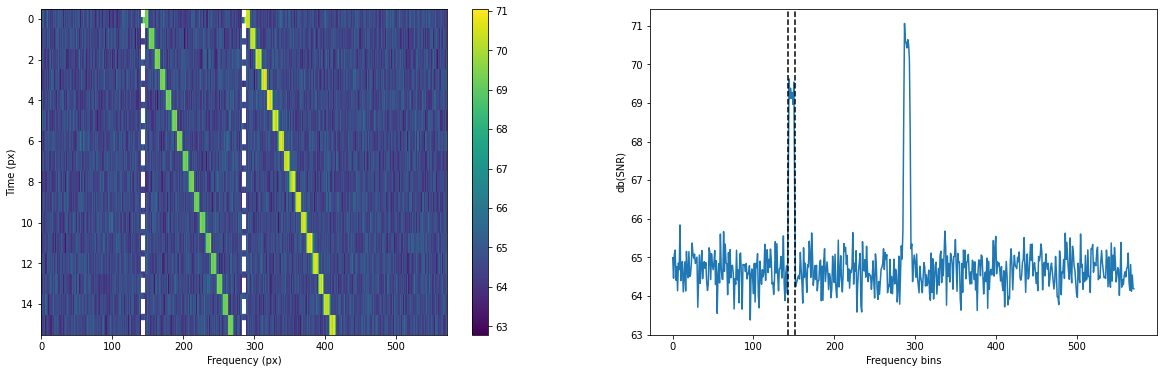

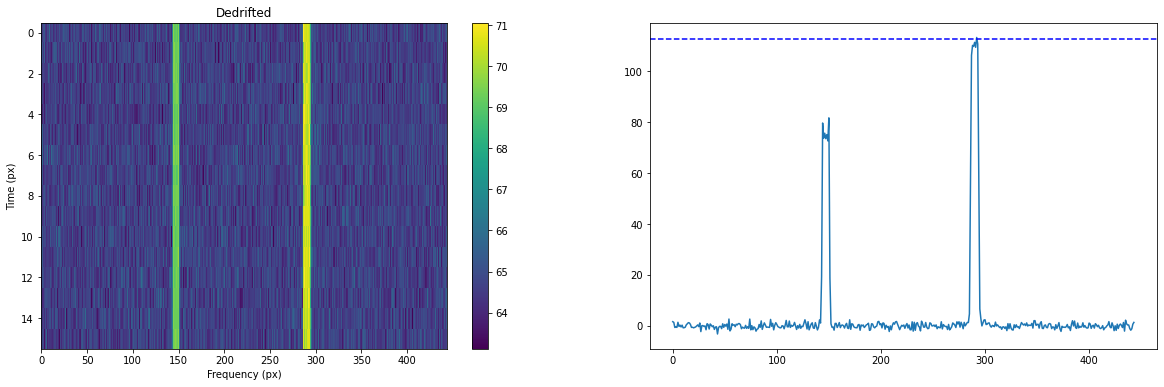

In [229]:
# RESET THE FRAME EVERY TIME 
# fr = stg.Frame.from_backend_params(430, 16)
f_start = fine_chan_bw * int(fftlength*(2+0.6-0.5))
wf = bl.Waterfall('drifting.rawspec.0000.fil',
                  f_start=f_start/1e6 - 4*200/1e6,
                  f_stop=f_start/1e6 + 4*200/1e6)
fr = stg.Frame.from_waterfall(wf)

drift_factor = 8
drift_rate = fr.df/fr.dt * drift_factor

def analytic_chirp(drift_rate, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * T / abs(dW)
    print(const)

    def f_profile(f, f_center):
#         df = 2 * np.pi * (f - f_center) + dW / 2

#         X1 = (dW / 2 + (df - dW)) / np.sqrt(np.pi * abs(dW) / T)
#         X2 = (dW / 2 - (df - dW)) / np.sqrt(np.pi * abs(dW) / T)

        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile

synth_i_start = fr.fchans // 4
synth_f_start = fr.get_frequency(synth_i_start)
fr.add_signal(stg.constant_path(f_start=synth_f_start,
                                drift_rate=drift_rate),
                          stg.constant_t_profile(level=fr.get_intensity(snr=100)),
                          analytic_chirp(drift_rate, fr.dt),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

fr.plot(use_db=True)

plt.axvline(synth_i_start, lw=4, c='w', ls='--')
plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')


plt.subplot(1, 2, 2)
spectrum = fr.data[i]
plt.plot(stg.db(spectrum))
plt.axvline(synth_i_start, ls='--', c='k')
plt.axvline(synth_i_start+(drift_rate*fr.dt)/fr.df, ls='--', c='k')

plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
dd_fr = stg.dedrift(fr, drift_rate)
dd_fr.plot(use_db=True)
plt.title('Dedrifted')

plt.subplot(1, 2, 2)
plt.plot(dd_fr.integrate(normalize=True))
plt.axhline(225/2, ls='--', c='b')
plt.show()

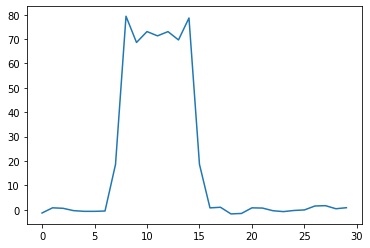

In [210]:
plt.plot(dd_fr.integrate(normalize=True)[100:130])

In [201]:
8*1.75

14.0

0.832665531104945


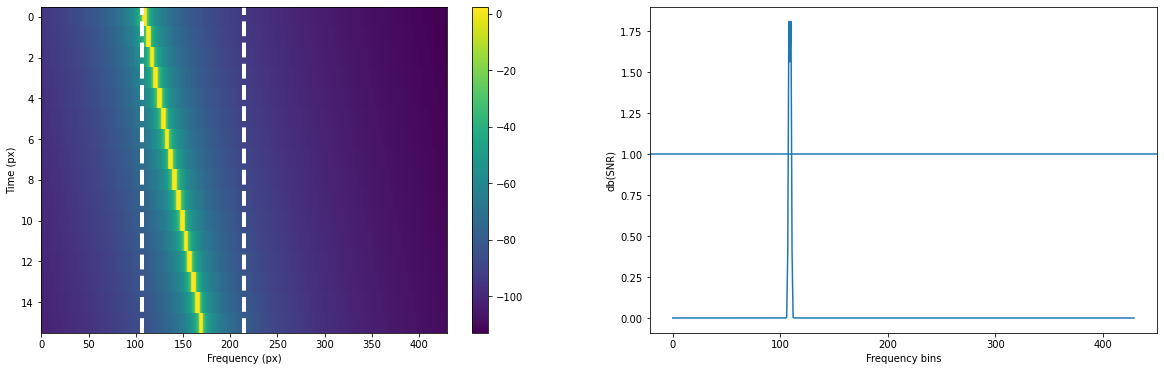

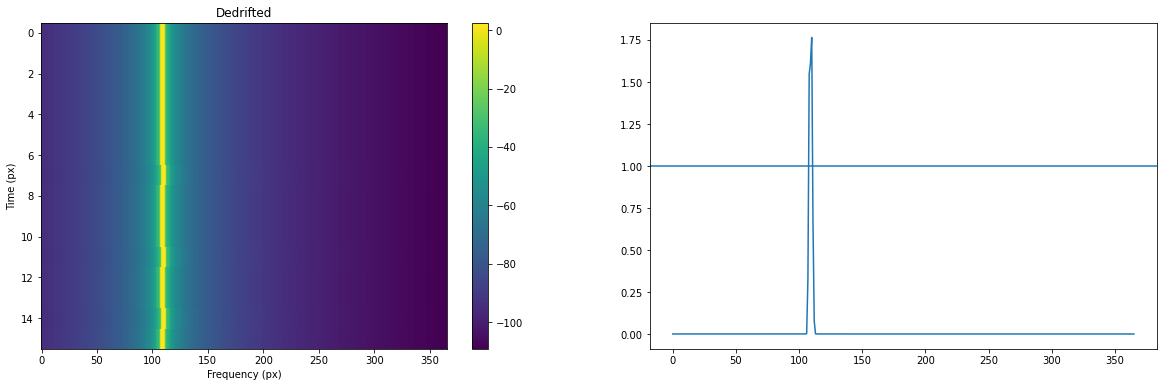

In [241]:
# RESET THE FRAME EVERY TIME 
fr = stg.Frame.from_backend_params(430, 16)

def analytic_chirp(drift_rate, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * T / abs(dW)
    print(const)  1 / 2  df 

    def f_profile(f, f_center):
#         df = 2 * np.pi * (f - f_center) + dW / 2

#         X1 = (dW / 2 + (df - dW)) / np.sqrt(np.pi * abs(dW) / T)
#         X2 = (dW / 2 - (df - dW)) / np.sqrt(np.pi * abs(dW) / T)

        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile


drift_factor = 4
drift_rate = fr.df/fr.dt * drift_factor

synth_i_start = fr.fchans // 4
synth_f_start = fr.get_frequency(synth_i_start)
fr.add_signal(stg.constant_path(f_start=synth_f_start,
                                drift_rate=drift_rate),
                          stg.constant_t_profile(level=1),
                          analytic_chirp(drift_rate, fr.dt),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

fr.plot(use_db=True)

plt.axvline(synth_i_start, lw=4, c='w', ls='--')
plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')


plt.subplot(1, 2, 2)
spectrum = fr.data[i]
plt.plot((spectrum))
# plt.axvline(synth_i_start, ls='--', c='k')
# plt.axvline(synth_i_start+(drift_rate*fr.dt)/fr.df, ls='--', c='k')
plt.axhline(1)

plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
dd_fr = stg.dedrift(fr, drift_rate)
dd_fr.plot(use_db=True)
plt.title('Dedrifted')

plt.subplot(1, 2, 2)
plt.plot(dd_fr.integrate(normalize=False))
plt.axhline(1)
plt.show()

In [242]:
drift_rate

0.6004812032227409

In [243]:
fftlength = 1048576
int_factor = 51
!rawspec -f $fftlength -t $int_factor -d . drifting_100snr

working stem: drifting_100snr
opening file: drifting_100snr.0000.raw
opening file: drifting_100snr.0001.raw
opening file: drifting_100snr.0002.raw
opening file: drifting_100snr.0003.raw
opening file: drifting_100snr.0004.raw
opening file: drifting_100snr.0005.raw
opening file: drifting_100snr.0006.raw
opening file: drifting_100snr.0007.raw
opening file: drifting_100snr.0008.raw
opening file: drifting_100snr.0009.raw
opening file: drifting_100snr.0010.raw
opening file: drifting_100snr.0011.raw
opening file: drifting_100snr.0012.raw
opening file: drifting_100snr.0013.raw
opening file: drifting_100snr.0014.raw [No such file or directory]
output product 0: 16 spectra


0.816652732429849


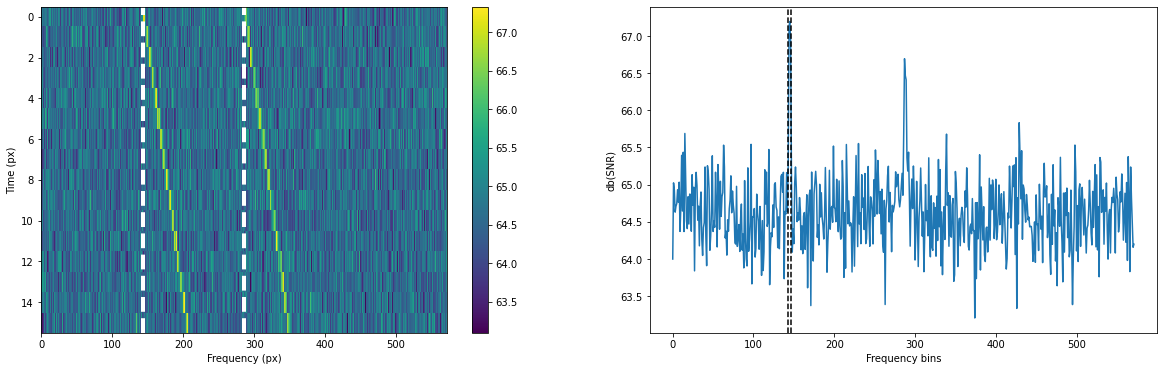

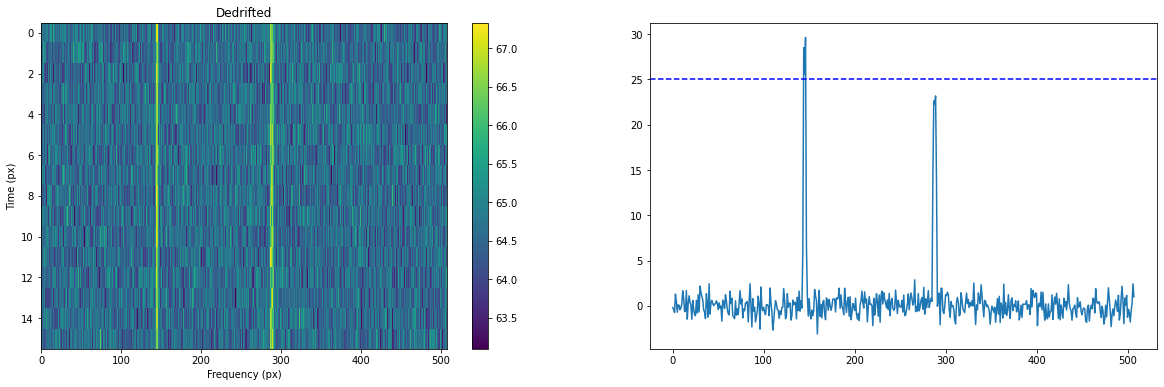

In [56]:
# RESET THE FRAME EVERY TIME 
# fr = stg.Frame.from_backend_params(430, 16)
f_start = fine_chan_bw * int(fftlength*(2+0.23-0.5))
wf = bl.Waterfall('drifting_100snr.rawspec.0000.fil',
                  f_start=f_start/1e6 - 4*200/1e6,
                  f_stop=f_start/1e6 + 4*200/1e6)
fr = stg.Frame.from_waterfall(wf)

drift_factor = 4
drift_rate = fr.df/fr.dt * drift_factor

def analytic_chirp(drift_rate, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * T / abs(dW)
    print(const)

    def f_profile(f, f_center):
#         df = 2 * np.pi * (f - f_center) + dW / 2

#         X1 = (dW / 2 + (df - dW)) / np.sqrt(np.pi * abs(dW) / T)
#         X2 = (dW / 2 - (df - dW)) / np.sqrt(np.pi * abs(dW) / T)

        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return 1/2 * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile

synth_i_start = fr.fchans // 4
synth_f_start = fr.get_frequency(synth_i_start)
fr.add_signal(stg.constant_path(f_start=synth_f_start,
                                drift_rate=drift_rate),
                          stg.constant_t_profile(level=fr.get_intensity(snr=100/drift_factor)),
                          analytic_chirp(drift_rate, fr.dt),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

fr.plot(use_db=True)

plt.axvline(synth_i_start, lw=4, c='w', ls='--')
plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')


plt.subplot(1, 2, 2)
spectrum = fr.data[0]
plt.plot(stg.db(spectrum))
plt.axvline(synth_i_start, ls='--', c='k')
plt.axvline(synth_i_start+(drift_rate*fr.dt)/fr.df, ls='--', c='k')

plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
dd_fr = stg.dedrift(fr, drift_rate)
dd_fr.plot(use_db=True)
plt.title('Dedrifted')

plt.subplot(1, 2, 2)
plt.plot(dd_fr.integrate(normalize=True))
plt.axhline(100/drift_factor, ls='--', c='b')
plt.show()

1.66533106220989
[0.91508276]
df: 2; level: 0.9150827632881129
1.1102207081399265
[0.97437199 0.97437199]
df: 3; level: 0.9743719940009067
0.832665531104945
[1.08745905 0.9393334  1.08745904]
df: 4; level: 1.0380838315681844
0.6661324248839561
[1.05842166 0.92851655 0.92851655 1.05842166]
df: 5; level: 0.9934691042211667
0.5551103540699632
[1.12891102 1.07989844 0.95022523 1.07989844 1.12891102]
df: 6; level: 1.073568831190516
0.4758088749171115
[0.93433979 0.92047551 1.06550622 1.06550622 0.92047551]
df: 7; level: 0.9812606480836047
0.4163327655524725
[1.10366688 0.94260113 1.04809481 0.95676535 1.04809481 0.94260113
 1.10366688]
df: 8; level: 1.0207844258454846
0.3700735693799756
[0.85709665 1.03820768 0.95417015 1.03499707 1.03499707 0.95417015
 1.03820768 0.85709665]
df: 9; level: 0.9711178888305299
0.33306621244197804
[1.03436131 1.08814351 1.06678179 1.01002958 0.96124975 1.01002958
 1.06678179 1.08814351 1.03436131]
df: 10; level: 1.0399869031325695
0.30278746585634364
[1.166256

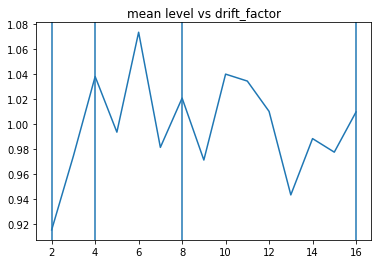

In [47]:
def analytic_chirp(drift_rate, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * T / abs(dW) #* drift_rate
    print(const) 

    def f_profile(f, f_center):
#         df = 2 * np.pi * (f - f_center) + dW / 2

#         X1 = (dW / 2 + (df - dW)) / np.sqrt(np.pi * abs(dW) / T)
#         X2 = (dW / 2 - (df - dW)) / np.sqrt(np.pi * abs(dW) / T)

        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return 1/2 * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile


x = list(np.arange(2, 17))
y = []
for drift_factor in x:
    fr = stg.Frame.from_backend_params(430, 16)

    drift_rate = fr.df/fr.dt * drift_factor

    synth_i_start = fr.fchans // 4
    synth_f_start = fr.get_frequency(synth_i_start)
    fr.add_signal(stg.constant_path(f_start=synth_f_start,
                                    drift_rate=drift_rate),
                              stg.constant_t_profile(level=1),
                              analytic_chirp(drift_rate, fr.dt),
                              stg.constant_bp_profile(level=1))

# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)

# fr.plot(use_db=True)

# plt.axvline(synth_i_start, lw=4, c='w', ls='--')
# plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')


# plt.subplot(1, 2, 2)
    spectrum = fr.data[0]
# plt.plot((spectrum))
# # plt.axvline(synth_i_start, ls='--', c='k')
# # plt.axvline(synth_i_start+(drift_rate*fr.dt)/fr.df, ls='--', c='k')
# plt.axhline(1)

# plt.xlabel('Frequency bins')
# plt.ylabel('db(SNR)')
# plt.show()

# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)
# dd_fr = stg.dedrift(fr, drift_rate)
# dd_fr.plot(use_db=True)
# plt.title('Dedrifted')

# plt.subplot(1, 2, 2)
# plt.plot(dd_fr.integrate(normalize=False))
# plt.axhline(1)
# plt.show()

    a = synth_i_start
    b = synth_i_start+int((drift_rate*fr.dt)/fr.df)+1
    level = np.mean(spectrum[a+1:b-1])
#     plt.figure(figsize=(12, 4))
#     plt.plot((spectrum))
#     plt.title(drift_factor)
#     plt.show()
    print(spectrum[a+1:b-1])
    print(f"df: {drift_factor}; level: {level}")
    y.append(level)
    
plt.plot(x, y)
plt.title('mean level vs drift_factor')
for i in [2, 4, 8, 16]:
    plt.axvline(i)
plt.show()

In [20]:
1/2/drift_rate

0.20816638277623625

In [26]:
2*np.pi/2

3.141592653589793

0.20816638277623625


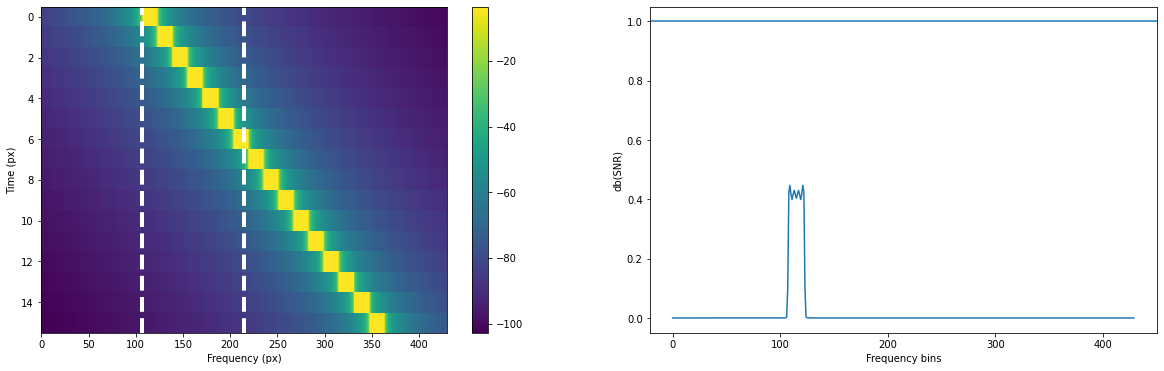

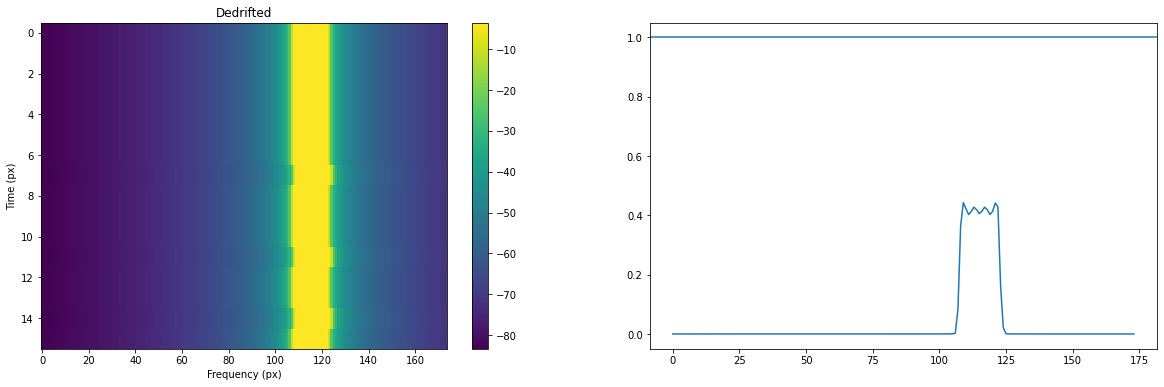

In [43]:
# RESET THE FRAME EVERY TIME 
fr = stg.Frame.from_backend_params(430, 16)

def analytic_chirp(drift_rate, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * T / abs(dW)
    print(const) 

    def f_profile(f, f_center):
#         df = 2 * np.pi * (f - f_center) + dW / 2

#         X1 = (dW / 2 + (df - dW)) / np.sqrt(np.pi * abs(dW) / T)
#         X2 = (dW / 2 - (df - dW)) / np.sqrt(np.pi * abs(dW) / T)

        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile


drift_factor = 4*4
drift_rate = fr.df/fr.dt * drift_factor

synth_i_start = fr.fchans // 4
synth_f_start = fr.get_frequency(synth_i_start)
fr.add_signal(stg.constant_path(f_start=synth_f_start,
                                drift_rate=drift_rate),
                          stg.constant_t_profile(level=1),
                          analytic_chirp(drift_rate, fr.dt),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

fr.plot(use_db=True)

plt.axvline(synth_i_start, lw=4, c='w', ls='--')
plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')


plt.subplot(1, 2, 2)
spectrum = fr.data[0]
plt.plot((spectrum))
# plt.axvline(synth_i_start, ls='--', c='k')
# plt.axvline(synth_i_start+(drift_rate*fr.dt)/fr.df, ls='--', c='k')
plt.axhline(1)

plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
dd_fr = stg.dedrift(fr, drift_rate)
dd_fr.plot(use_db=True)
plt.title('Dedrifted')

plt.subplot(1, 2, 2)
plt.plot(dd_fr.integrate(normalize=False))
plt.axhline(1)
plt.show()

0.20816638277623625


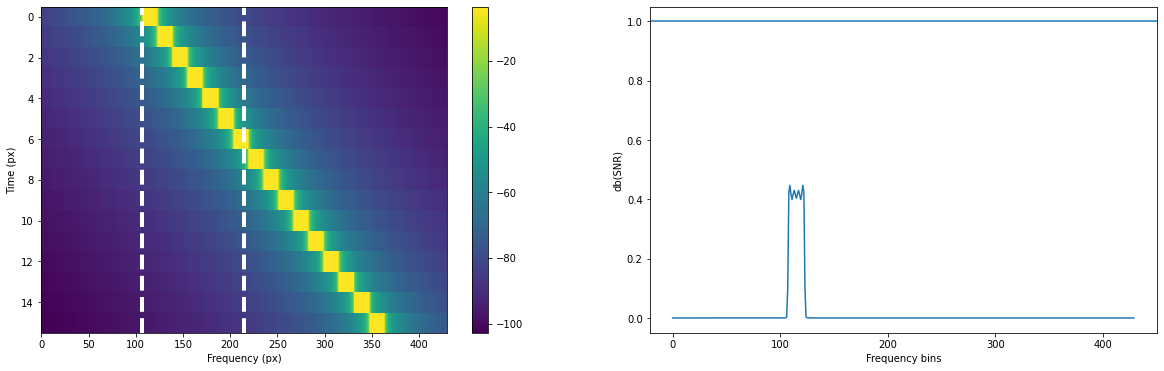

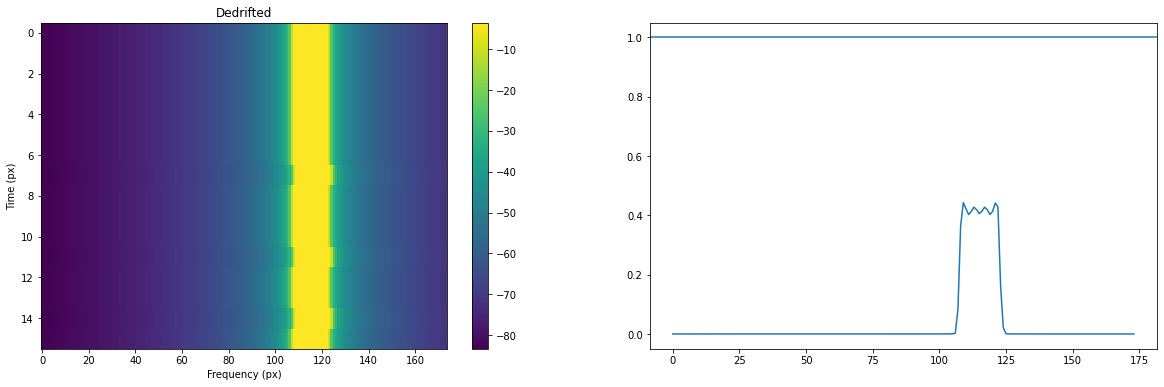

In [57]:
# RESET THE FRAME EVERY TIME 
fr = stg.Frame.from_backend_params(430, 16)

def analytic_chirp(drift_rate, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, so dOmega is adjusted
    from the frequency range accordingly. Also f_start
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * T / abs(dW)
    print(const) 

    def f_profile(f, f_center):
#         df = 2 * np.pi * (f - f_center) + dW / 2

#         X1 = (dW / 2 + (df - dW)) / np.sqrt(np.pi * abs(dW) / T)
#         X2 = (dW / 2 - (df - dW)) / np.sqrt(np.pi * abs(dW) / T)

        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile


drift_factor = 4*4
drift_rate = fr.df/fr.dt * drift_factor

synth_i_start = fr.fchans // 4
synth_f_start = fr.get_frequency(synth_i_start)
fr.add_signal(stg.constant_path(f_start=synth_f_start,
                                drift_rate=drift_rate),
                          stg.constant_t_profile(level=1),
                          analytic_chirp(drift_rate, fr.dt))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

fr.plot(use_db=True)

plt.axvline(synth_i_start, lw=4, c='w', ls='--')
plt.axvline(fr.fchans // 2, lw=4, c='w', ls='--')


plt.subplot(1, 2, 2)
spectrum = fr.data[0]
plt.plot((spectrum))
# plt.axvline(synth_i_start, ls='--', c='k')
# plt.axvline(synth_i_start+(drift_rate*fr.dt)/fr.df, ls='--', c='k')
plt.axhline(1)

plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.show()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
dd_fr = stg.dedrift(fr, drift_rate)
dd_fr.plot(use_db=True)
plt.title('Dedrifted')

plt.subplot(1, 2, 2)
plt.plot(dd_fr.integrate(normalize=False))
plt.axhline(1)
plt.show()

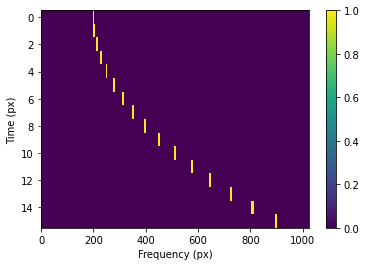

In [98]:
frame = stg.Frame.from_backend_params(1024, 16)
signal = frame.add_signal(stg.squared_path(f_start=frame.get_frequency(200),
                                           drift_rate=0.05*u.Hz/u.s),
                          stg.constant_t_profile(level=1),
                          stg.box_f_profile(width=20*u.Hz),
                          stg.constant_bp_profile(level=1))
frame.plot()

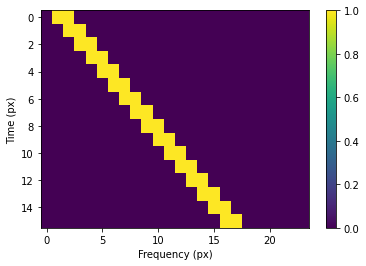

In [182]:
frame = stg.Frame.from_backend_params(24, 16)
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(2)-frame.df/2,
                                           drift_rate=frame.df/frame.dt),
                          stg.constant_t_profile(level=1),
                          stg.box_f_profile(width=2*frame.df),
                          stg.constant_bp_profile(level=1))
frame.plot()

i'd need to adjust ff between path_tt value and the next

In [64]:
np.meshgrid([1,2],[0,1])

[array([[1, 2],
        [1, 2]]),
 array([[0, 0],
        [1, 1]])]

In [70]:
np.repeat([[1,2,3]], 4, axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [85]:
np.broadcast_to([1,2,3], (2,3)).T

array([[1, 1],
       [2, 2],
       [3, 3]])

In [112]:
ts_appended = [1, 2, 4, 6, 10]
ff, tt = np.meshgrid(np.arange(20),ts_appended[:-1])
ff, tt

(array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19]]),
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]]))

In [113]:
np.diff(ts_appended)

array([1, 2, 2, 4])

In [115]:
ts_appended[:-1], ts_appended[1:]

slice([1, 2, 4, 6], [2, 4, 6, 10], None)

In [171]:
path = np.array([101, 102, 104, 106, 107])
np.digitize([101, 102, 103, 104, 104.1], path, right=False) - 1

array([0, 1, 1, 2, 2])

In [187]:
num_smear = 1

path = np.array([101, 102, 104, 106, 103, 107]).astype(float)
path_a = np.append(path, 112)

dpath = np.diff(path_a) / num_smear
for _ in range(num_smear):
    print(path)
    path += dpath

[101. 102. 104. 106. 103. 107.]


In [189]:
frame.ts

array([  0.        ,  18.61152495,  37.2230499 ,  55.83457485,
        74.4460998 ,  93.05762475, 111.6691497 , 130.28067465,
       148.89219959, 167.50372454, 186.11524949, 204.72677444,
       223.33829939, 241.94982434, 260.56134929, 279.17287424])

AttributeError: 'Frame' object has no attribute 'tmax'

In [172]:
path = np.array([101, 102, 104, 106, 103, 107])
path_a = np.append(path, 112)

fs = np.arange(100, 113)
ff, tt = np.meshgrid(fs, path_a[:-1])

idx = np.digitize(path_a, fs) - 1

for r in range(len(path_a) - 1):
    i1, i2 = idx[r], idx[r + 1]
    
    f_center = fs[i1]
    if i1 < i2:
        ff[r, i1:i2] = f_center
    else:
        # Include i2 when setting the value, if i2 > i1
        ff[r, i1+1:i2+1] = f_center
    
    f = path_a[i]
    f_min = min(f, path_a[i+1])
    
    f_diff = abs(np.diff(path_a)[i])
    for j in range(f_diff):
        ff[i, f_min + j] = f
    ff[i, f_min + f_diff:] -= f_diff - 1
ff

[ 1  2  4  6  3  7 12]


TypeError: _digitize_dispatcher() missing 2 required positional arguments: 'x' and 'bins'

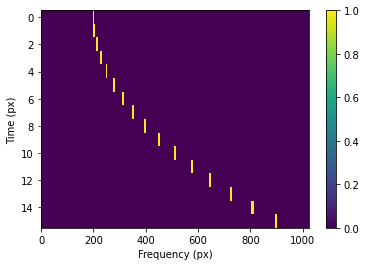

In [191]:
frame = stg.Frame.from_backend_params(1024, 16)
signal = frame.add_signal(stg.squared_path(f_start=frame.get_frequency(200),
                                           drift_rate=0.05*u.Hz/u.s),
                          stg.constant_t_profile(level=1),
                          stg.box_f_profile(width=20*u.Hz),
                          stg.constant_bp_profile(level=1))
frame.plot()

[0.08659721 0.25979165 0.43298607 0.60618051 0.77937494 0.95256937
 1.1257638  1.29895823 1.47215266 1.64534709 1.81854152 1.99173594
 2.16493038 2.33812482 2.51131924 2.68451367]


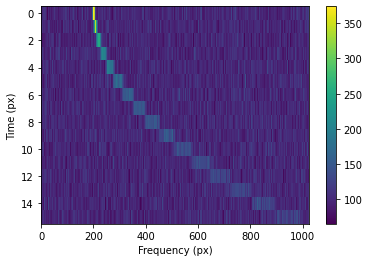

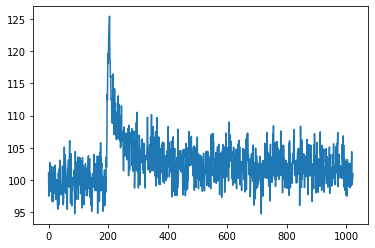

In [280]:
frame = stg.Frame.from_backend_params(1024, 16)
frame.add_noise(100)
signal = frame.add_signal(stg.squared_path(f_start=frame.get_frequency(200),
                                           drift_rate=0.05*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=100)),
                          stg.box_f_profile(width=frame.df*10),
                          stg.constant_bp_profile(level=1),
                          num_smear=10)
frame.plot()
plt.show()

plt.plot(frame.integrate())
plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


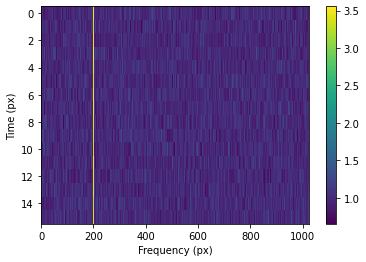

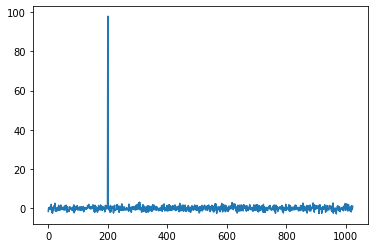

In [285]:
frame = stg.Frame.from_backend_params(1024, 16)
frame.add_noise(1)
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(200),
                                            drift_rate=0*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=100)),
                          stg.box_f_profile(width=frame.df*1),
                          stg.constant_bp_profile(level=1),
                          num_smear=10)
frame.plot()
plt.show()

plt.plot(frame.integrate(normalize=True))
plt.show()

[2.79396772 2.79396772 2.79396772 2.79396772 2.79396772 2.79396772
 2.79396772 2.79396772 2.79396772 2.79396772 2.79396772 2.79396772
 2.79396772 2.79396772 2.79396772 2.79396772]


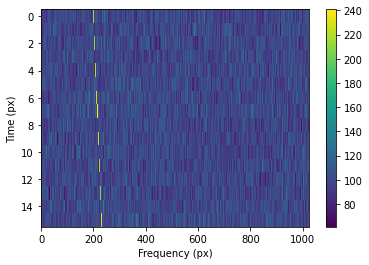

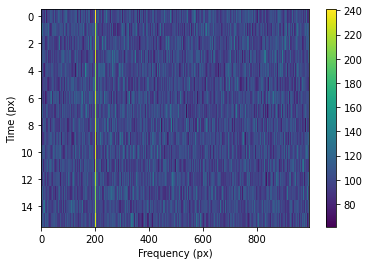

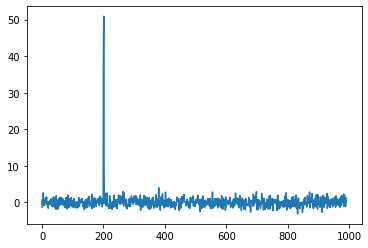

In [343]:
frame = stg.Frame.from_backend_params(1024, 16)
frame.add_noise(100)

drift_factor = 2
drift_rate = drift_factor * frame.unit_drift_rate
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(200),
                                            drift_rate=drift_rate),
                          stg.constant_t_profile(level=frame.get_intensity(snr=100)),
                          stg.box_f_profile(width=frame.df*1),
                          num_smear=drift_factor)
frame.plot()
plt.show()

stg.dedrift(frame, drift_rate).plot()
plt.show()

plt.plot(stg.dedrift(frame, drift_rate).integrate(normalize=True))
plt.show()

[ 3.15763149e-01  6.88894577e-01 -1.43570661e+00  1.88318213e+00
  7.45648956e-02  2.08617039e-01 -6.94804115e-01  7.99823923e-01
 -1.93757844e+00  1.01257520e+00  5.44859858e-01 -2.51054318e+00
 -4.15897369e-04  6.36704168e-01  2.25291646e+00 -3.03195076e-01]


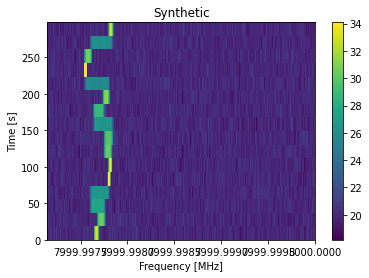

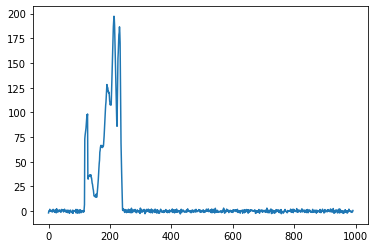

In [357]:
frame = stg.Frame.from_backend_params(1024, 16)
frame.add_noise(100)

drift_factor = 2
drift_rate = drift_factor * frame.unit_drift_rate
signal = frame.add_signal(stg.simple_rfi_path(f_start=frame.get_frequency(200),
                                              drift_rate=0*u.Hz/u.s,
                                     spread=300*u.Hz,
                                     spread_type='uniform',
                                     rfi_type='stationary'),
                          stg.constant_t_profile(level=frame.get_intensity(snr=1000)),
                          stg.box_f_profile(width=frame.df*10),
                          num_smear=100)
frame.bl_plot()
plt.show()

plt.plot(stg.dedrift(frame, drift_rate).integrate(normalize=True))
plt.show()

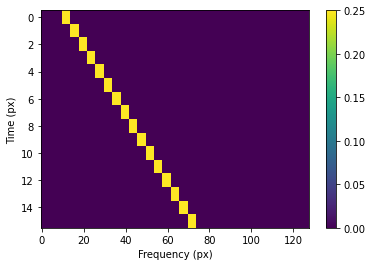

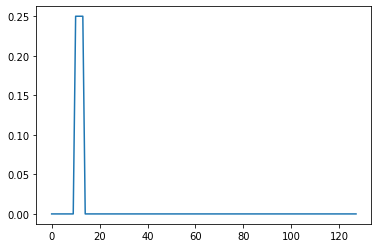

In [131]:
frame = stg.Frame.from_backend_params(128, 16)
# frame.add_noise(1)

drift_factor = 4
drift_rate = drift_factor * frame.unit_drift_rate
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(10),
                                              drift_rate=drift_rate),
                          stg.constant_t_profile(level=1),
                          stg.box_f_profile(width=frame.df*1),
                          integrate_path=False,
                          integrate_t_profile=False,
                          doppler_smearing=True,
                          smearing_subsamples=drift_factor)
frame.plot()
plt.show()

plt.plot(frame.data[0])
plt.show()


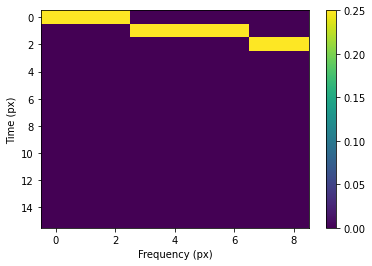

In [132]:
frame.get_slice(11,20).plot()
plt.show()

2.0
38 106


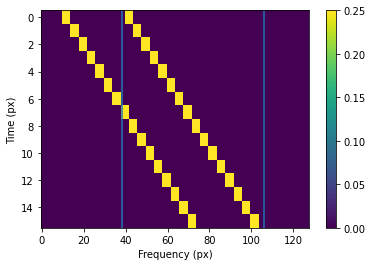

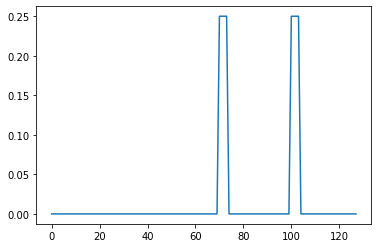

In [180]:
frame = stg.Frame.from_backend_params(128, 16)
# frame.add_noise(1)

drift_factor = 4
drift_rate = drift_factor * frame.unit_drift_rate
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(10),
                                              drift_rate=drift_rate),
                          stg.constant_t_profile(level=1),
                          stg.box_f_profile(width=frame.df*1),
                          integrate_path=False,
                          integrate_t_profile=False,
                          doppler_smearing=True,
                          smearing_subsamples=drift_factor)

frame.add_constant_signal(frame.get_frequency(40), drift_rate,
                          1, frame.df*1, 'box', True)
frame.plot()
plt.axvline(38)
plt.axvline(106)
plt.show()
dd
plt.plot(frame.data[-1])
plt.show()


In [182]:
frame = stg.Frame.from_backend_params(1024, 16)
frame.get_params()

{'fchans': 1024,
 'tchans': 16,
 'df': 2.7939677238464355,
 'dt': 18.611524949333333,
 'fch1': 8000000000.0,
 'ascending': False}

In [187]:
stg.frame.params_from_backend(16)

18.75


{'tchans': 16, 'df': 2.7939677238464355, 'dt': 18.611524949333333}

In [191]:
18.253611008*2.7939677238464355

51.0

In [190]:
stg.frame.params_from_backend(int_factor=51)

{'tchans': 16, 'df': 2.7939677238464355, 'dt': 18.253611008}

In [13]:
stg.Frame(fchans=1024, tchans=32).get_params()

{'fchans': 1024,
 'tchans': 32,
 'df': 2.7939677238464355,
 'dt': 18.253611008,
 'fch1': 8000000000.0,
 'ascending': False}

In [14]:
stg.Frame(shape=(32, 1024)).get_params()

{'fchans': 1024,
 'tchans': 32,
 'df': 2.7939677238464355,
 'dt': 18.253611008,
 'fch1': 8000000000.0,
 'ascending': False}

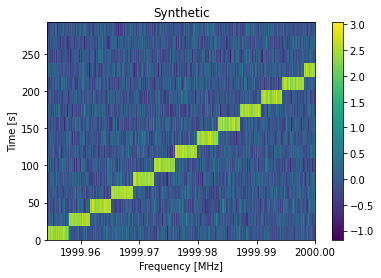

In [23]:
frame = stg.Frame(shape=(16, 1024*16), fch1=2*u.GHz)
frame.add_noise(1)

# drift_factor = 4
drift_rate = 200
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(10),
                                              drift_rate=drift_rate),
                          stg.constant_t_profile(level=1000),
                          stg.box_f_profile(width=frame.df*1),
                          doppler_smearing=True,
                          smearing_subsamples=int(drift_rate/frame.unit_drift_rate))

frame.bl_plot()
plt.show()

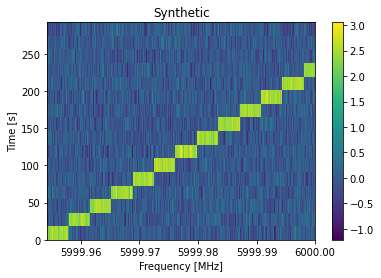

In [25]:
fr = stg.Frame(shape=(16, 1024*16))
fr.add_noise(1)
drift_factor = drift_rate / fr.unit_drift_rate
fr.add_constant_signal(f_start=fr.get_frequency(10)+fr.df * drift_factor/2,
                       drift_rate=drift_rate,
                       level=1000 / drift_factor,
                       width=fr.df * drift_factor,
                       f_profile_type='box')
fr.bl_plot()
plt.show()